## Setup

### Import libraries

In [56]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

from pyzipcode import ZipCodeDatabase

from xgboost import XGBRegressor, plot_tree


### Import data

In [57]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

## Exploration

In [58]:
df.shape

(20000, 21)

In [59]:
df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,4580297056.71,3.37,2.12,2079.88,15015.33,1.50,0.01,0.23,3.41,7.66,1790.23,289.65,1971.10,82.73,98077.88,47.56,-122.21,1986.39,12748.96,539436.71
std,2875294849.89,0.93,0.77,919.43,39701.35,0.54,0.09,0.77,0.65,1.18,829.59,441.54,29.37,397.87,53.44,0.14,0.14,685.21,27076.49,366433.44
min,1000102.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,75000.00
25%,2123049478.50,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.75,0.00,98033.00,47.47,-122.33,1490.00,5100.00,322000.00
50%,3904955440.00,3.00,2.25,1910.00,7620.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7622.00,450000.00
75%,7309825262.50,4.00,2.50,2550.00,10710.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98117.00,47.68,-122.12,2360.00,10088.25,641625.00
max,9900000190.00,33.00,8.00,13540.00,1164794.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00,7700000.00


In [60]:
df['date'].value_counts()

date
20140623T000000    135
20140626T000000    123
20140625T000000    120
20140708T000000    117
20150427T000000    116
                  ... 
20140727T000000      1
20150527T000000      1
20150524T000000      1
20140830T000000      1
20141115T000000      1
Name: count, Length: 370, dtype: int64

In [61]:
# graph average house price with waterfront is 1 vs 0

avg_price_by_waterfront = df.groupby('waterfront')['price'].median().reset_index()

fig = px.bar(avg_price_by_waterfront, x='waterfront', y='price',
             labels={'waterfront': 'Waterfront', 'price': 'Average Price'},
             title='Average House Price by Waterfront')

fig.show()


#### Find the state that each house is in, by zip

In [62]:
# zcdb = ZipCodeDatabase()

# def get_state_from_zip(zip):
#   try:
#     return zcdb[zip].state
#   except:
#     return np.nan

# df["state"] = df["zipcode"].map(get_state_from_zip)

# df["state"].value_counts()

# They're all in Washington!

## Data cleaning

#### Formatting dates

In [63]:
df["yr_sold"] = df["date"].str[0:4].to_numpy(np.int64)
df["mnth_sold"] = df["date"].str[4:6].to_numpy(np.int64)

df = df.drop(columns=['id', 'date'])

# pd.to_datetime(df['date'])

#### Categorize year renovated

In [64]:
# Create was_renoved column, true or false
df['was_renovated'] = df['yr_renovated'] != 0
df = df.drop(columns=['yr_renovated'])

df['was_renovated'].value_counts()

was_renovated
False    19171
True       829
Name: count, dtype: int64

#### Remove price outliers

In [65]:
df = df[df["price"] < 4000000]

## Create model

In [66]:
X = pd.get_dummies(df.drop(["price"], axis=1))
y = df["price"]

model = XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,mnth_sold,was_renovated
0,4,3.25,3760,4675,2.00,0,0,3,8,2740,1020,2007,98038,47.39,-122.05,3280,4033,2014,11,False
1,3,1.75,1460,7800,1.00,0,0,2,7,1040,420,1979,98023,47.30,-122.38,1310,7865,2015,1,False
2,4,1.00,1340,5800,1.50,0,2,3,7,1340,0,1914,98116,47.57,-122.39,1900,5800,2014,10,False
3,3,1.75,1440,8050,1.00,0,0,3,8,1440,0,1985,98023,47.32,-122.39,1790,7488,2014,12,False
4,2,1.50,1780,4750,1.00,0,0,4,7,1080,700,1947,98117,47.69,-122.39,1690,5962,2014,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,1.50,1000,6914,1.00,0,0,3,7,1000,0,1947,98125,47.71,-122.32,1000,6947,2014,11,False
19996,3,2.50,3087,5002,2.00,0,0,3,8,3087,0,2014,98023,47.30,-122.35,2927,5183,2014,11,False
19997,3,2.50,2120,4780,2.00,0,0,3,7,2120,0,2004,98053,47.68,-122.03,1690,2650,2014,9,False
19998,1,0.75,380,15000,1.00,0,0,3,5,380,0,1963,98168,47.48,-122.32,1170,15000,2014,6,False


### Model stats

In [67]:
sse = np.sum((y_test - y_pred) ** 2)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

display(sse)
display(mse)
display(rmse)
display(r2)

52073167665979.49

13024804318.6542

114126.26480637224

0.8906061555946535

## Evaluate Mini dataset

In [68]:
mini = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")

### Do transformations

In [69]:
X = mini.drop(columns=['id'])
X["yr_sold"] = X["date"].str[0:4].to_numpy(np.int64)
X["mnth_sold"] = X["date"].str[4:6].to_numpy(np.int64)
X = pd.get_dummies(X.drop(["date"], axis=1))

X['was_renovated'] = X['yr_renovated'] != 0
X = X.drop(columns=['yr_renovated'])

X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,mnth_sold,was_renovated
0,4,1.75,2120,7680,1.00,0,0,4,7,1060,1060,1950,98177,47.72,-122.36,1530,7680,2014,11,False
1,4,2.25,2010,15375,1.00,0,0,4,8,2010,0,1957,98005,47.60,-122.17,1930,15375,2015,2,False
2,2,1.00,1070,4200,1.00,0,0,4,6,1070,0,1983,98002,47.33,-122.22,1150,4200,2015,1,False
3,4,2.50,1890,15770,2.00,0,0,4,7,1890,0,1968,98166,47.43,-122.34,2410,15256,2014,7,False
4,3,2.50,1600,2610,2.00,0,0,3,8,1600,0,2005,98027,47.53,-122.07,1445,1288,2014,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,4,2.75,2260,7209,1.00,0,3,3,7,1330,930,2002,98125,47.71,-122.30,1790,10860,2015,4,False
77,5,2.25,3480,9200,2.00,0,0,3,8,3480,0,1979,98006,47.56,-122.15,3130,9200,2014,7,False
78,5,2.75,2580,9242,2.00,0,2,4,8,1720,860,1967,98007,47.59,-122.13,2240,9316,2014,9,False
79,2,2.00,1590,8000,1.00,0,0,3,7,910,680,1984,98055,47.46,-122.20,1590,8364,2015,3,False


### Generate predictions and csv

In [70]:
mini_pred = model.predict(X)
mini_pred = pd.DataFrame(mini_pred, columns=['price'])
mini_pred.to_csv("Levi-predictions.csv", index=False)

### Feature importances

<Axes: >

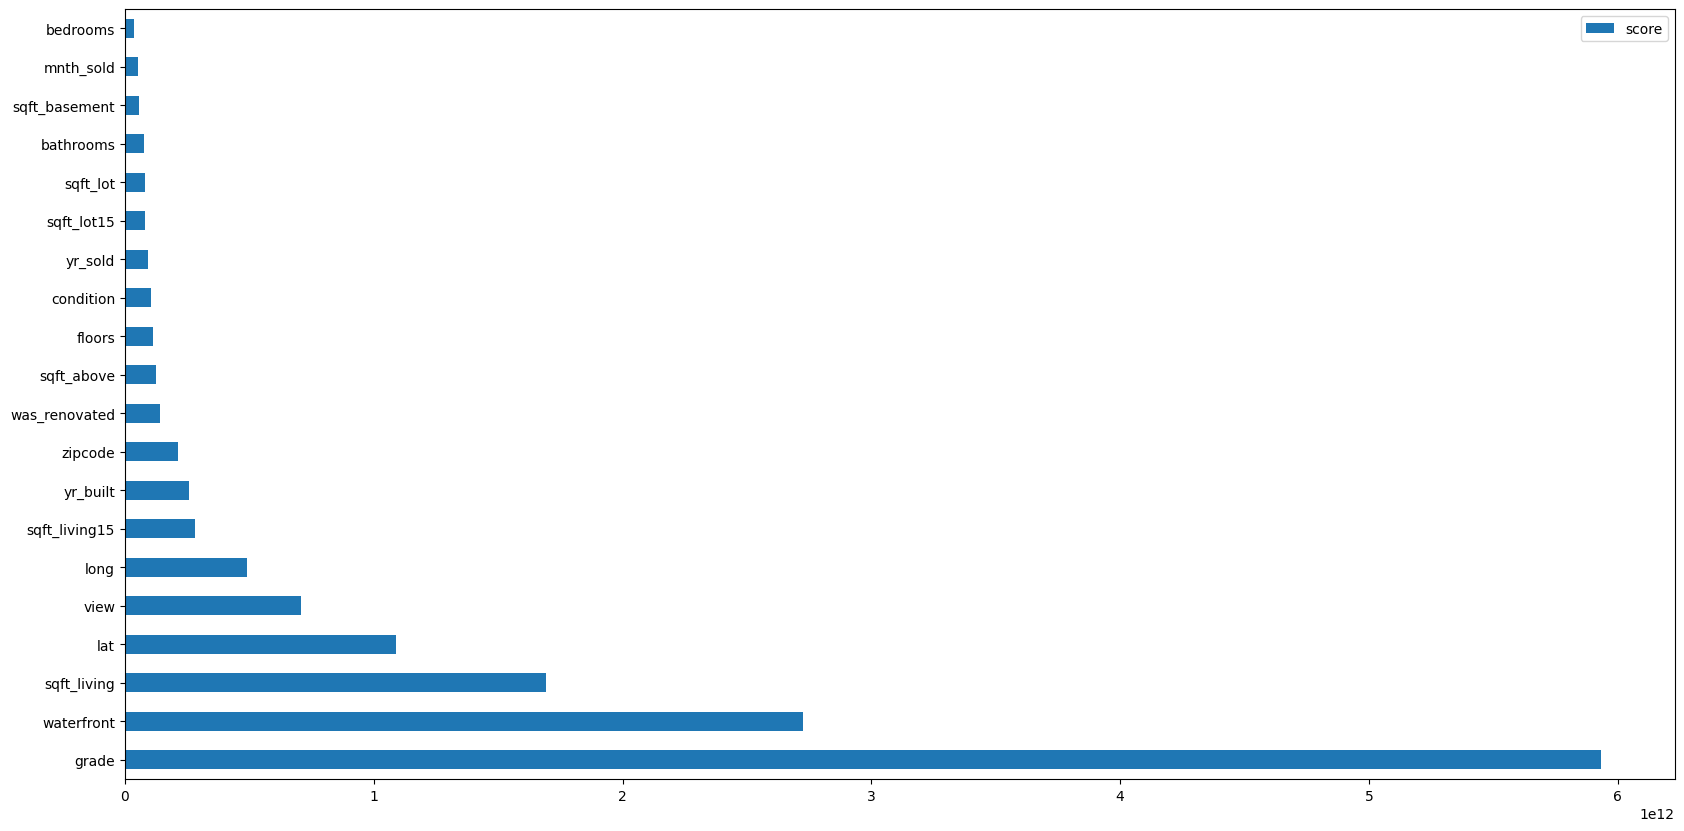

In [71]:
# compare weight vs gain here
# weight = how many splits are based on that feature
# gain = how much the accuracy is affected by the feature
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### Graph the decision tree

In [72]:
# Commented out for performance

# plot_tree(model, num_trees=2, rankdir='LR')
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(150, 100)
# fig.savefig('tree.png', bbox_inches='tight')

### Find the zip codes with the lowest home prices

In [167]:
df_lowest_zips = df.copy()
df_lowest_zips = df.groupby('zipcode', as_index=False)['price'].mean()
df_lowest_zips = df_lowest_zips.sort_values(by='price')
# df_lowest_zips = df_lowest_zips.head(15)

# Select the zip codes with the lowest home prices
print(df_lowest_zips[['zipcode', 'price']])
print(df_lowest_zips.dtypes)

    zipcode      price
1     98002  235085.47
64    98168  241003.91
20    98032  253325.25
0     98001  282335.56
61    98148  285211.02
..      ...        ...
47    98109  878483.08
48    98112 1095133.22
25    98040 1176956.41
3     98004 1316314.16
24    98039 1935103.02

[70 rows x 2 columns]
zipcode      int64
price      float64
dtype: object


### Get income by zip using a census dataset

In [169]:
census_df = pd.read_csv('census_zip_income/ACSST5Y2018.S1901-Data.csv')

census_df = census_df.rename(columns={
    'Geographic Area Name': 'zipcode',
    'Estimate!!Households!!Mean income (dollars)': 'household_mean_income',
    'Estimate!!Families!!Mean income (dollars)': 'families_mean_income',
    'Estimate!!Nonfamily households!!Mean income (dollars)': 'nonfamily_mean_income',
})

income_cols = ['household_mean_income', 'families_mean_income', 'nonfamily_mean_income']

# Simplify dataset to just these columns
census_df = census_df[income_cols + ['zipcode']]

# Strip off ZCTA5 (Zip code tabulationi area) prefix
census_df['zipcode'] = census_df['zipcode'].str[6:].astype(int)

# Clean income cols and drop invalid values
census_df[income_cols] = census_df[income_cols].replace(['-', 'N'], np.nan)
# census_df.dropna(subset=income_cols, inplace=True)

# Scale income cols to be in dollars
census_df[income_cols] = census_df[income_cols].map(lambda x: x)

# Join the census dataset to the our zip codes
df_lowest_zips = pd.merge(df_lowest_zips, census_df, on='zipcode', how='left')

df_lowest_zips

,zipcode,price,household_mean_income,families_mean_income,nonfamily_mean_income
0,98002,235085.47,64742,73500,46349
1,98168,241003.91,72280,78402,54437
2,98032,253325.25,75984,86230,56199
3,98001,282335.56,97847,102416,77212
4,98148,285211.02,73879,86196,49198
...,...,...,...,...,...
65,98109,878483.08,129064,189144,99771
66,98112,1095133.22,199439,270168,129055
67,98040,1176956.41,219325,264112,107089
68,98004,1316314.16,185707,232636,121828


### Graph median house price by income

In [172]:
# Melt the dataset income columns so we can plot them as separate lines in the plot
df_melted = df_lowest_zips.melt(id_vars=['price'], value_vars=income_cols, var_name='income_type', value_name='income')

# Data isn't really interesting to graph above this value
df_melted = df_melted[df_melted['price'] < 1500000]

# Create the line plot
fig = px.line(df_melted, x='price', y='income', color='income_type', title='Home Price vs Mean Income by Zip Code')

fig.show()